In [1]:
using DrWatson

@quickactivate "Hadjivasiliou_Julia_Tutorial"

projectname()

"Hadjivasiliou_Julia_Tutorial"

In [2]:
using DifferentialEquations
using Distributed
using Turing
using Distributions
using LinearAlgebra

using Plots
using StatsPlots

using Base.Threads
using Base.Threads: @spawn

# https://turing.ml/dev/docs/using-turing/guide


Next ODE: morphogen gradient - diffusion and linear degradation term

$\frac{\partial c}{\partial t} = D \frac{\partial ^ 2 c}{\partial x ^2}  - kc$

with source term $D\frac{\partial c}{\partial x}|_{x=0} = -j_0$ and zero flux at the end of the tissue, $D\frac{\partial c}{\partial x}|_{x=L} = 0$

The analytic solution $c(x) = c_0\exp(-x/\lambda$), where $c_0 = \frac{j_0}{\sqrt{Dk}}$ and $\lambda = \sqrt{\frac{D}{k}}$

MOL, Second-order central

https://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/

In [3]:
const Nc = 100
const L = 1.

const tissue = range(0,L,length = Nc)

const dx = step(tissue)
const h = 1/dx^2

const k = 1.
const j0 = 0.4

function morph_grad!(du,u,p,t)

    D = p

    du[1] = h*(2*u[2] + (2*dx*j0/D) - 2*u[1]) - k*u[1]

    @inbounds for j in 2:Nc-1
        du[j] =  D*h*(u[j-1] + u[j+1] - 2*u[j]) - k*u[j]
    end

    du[Nc] = h*(2*u[Nc-1] - 2*u[Nc]) - k*u[Nc]
    
end

morph_grad! (generic function with 1 method)

In [4]:
D = 0.16

p = (D)

u0 = zeros(Nc)

tspan = (0,12.)

prob = ODEProblem(morph_grad!,u0,tspan,p);

sol = solve(prob, AutoTsit5(Rosenbrock23()),save_everystep = false);

In [5]:
# https://turing.ml/dev/tutorials/10-bayesian-differential-equations/

In [17]:
function prob_func(prob,i,repeat)
    remake(prob,p=(rand()))
end

function output_func(sol,i)
    (sol.u[end],false)
end

ensemble_prob = EnsembleProblem(ODEProblem(morph_grad!,u0,tspan,p),prob_func = prob_func,output_func = output_func)

sol = solve(ensemble_prob,AutoTsit5(Rosenbrock23()),save_everystep = false, EnsembleThreads(),trajectories=1000)

EnsembleSolution Solution of length 1000 with uType:
Vector{Float64}

In [22]:
mat_sol = reduce(hcat,sol.u)

mean_sol = mean(mat_sol,dims = 2)
std_sol = std(mat_sol,dims = 2)

plot(tissue,mean_sol,ribbon = std_sol, xaxis = "Tissue",yaxis = "Morphogen Concentration", title = "Dist. of Morphogen Concentrations for random D",label = "Mean")
savefig(plotsdir("MorphogenDistribution.png"))

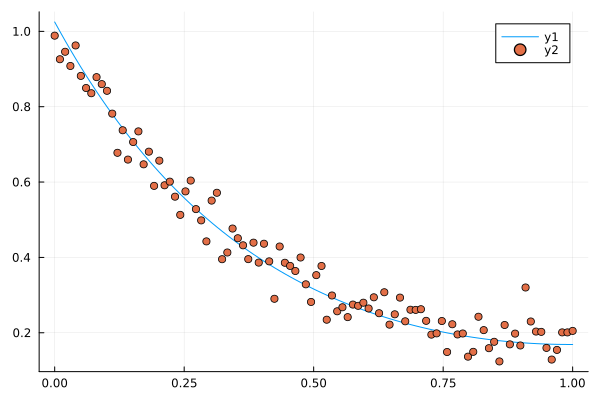

In [6]:
const σ_noise = 0.2

d = Normal(0.0,σ_noise^2)

odedata = sol(tspan[2]) .+ rand(d,length(sol(tspan[2])))

plot(tissue,sol.u[end])
scatter!(tissue,odedata)

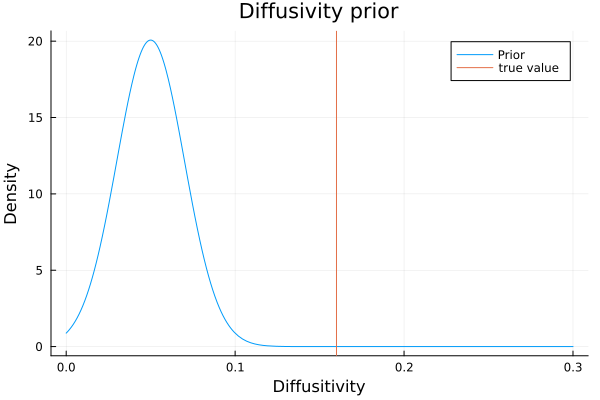

In [7]:
plot(truncated(Normal(0.05, 0.02); lower=0., upper=0.3),title = "Diffusivity prior", label = "Prior", xaxis = "Diffusitivity", yaxis = "Density")
vline!([D],label = "true value")

# savefig(plotsdir("DiffusitivityPrior.png"))

In [8]:
@model function fitlv(data, prob)
    # Prior distributions.
    D ~ truncated(Normal(0.05, 0.02); lower=0., upper=0.5)

    # Simulate morphogen model. 
    p = (D)
    predicted = solve(prob, AutoTsit5(Rosenbrock23()); p=p, save_everystep = false).u[end]

    data = MvNormal(predicted, σ_noise^2 * I)

    return nothing
end

fitlv (generic function with 2 methods)

In [9]:
model = fitlv(odedata, prob);

In [10]:
chain = sample(model, NUTS(0.65), MCMCSerial(), 10000, 1; progress=true)

Sampling (Chain 1 of 1)   0%|                           |  ETA: N/A


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/boothh/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling (Chain 1 of 1)   0%|▏                          |  ETA: 1:17:58


Sampling (Chain 1 of 1)   1%|▎                          |  ETA: 0:44:38


┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/boothh/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548


┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:496
┌ Warning: Automatic dt set the starting dt as NaN, causing instability. Exiting.
└ @ OrdinaryDiffEq /Users/boothh/.julia/packages/OrdinaryDiffEq/4qO6L/src/solve.jl:548
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ SciMLBase /Users/boothh/.julia/packages/SciMLBase/6ZvYQ/src/integrator_interface.jl:496
Sampling (Chain 1 of 1)   2%|▍                          |  ETA: 0:35:29


Sampling (Chain 1 of 1)   2%|▌                          |  ETA: 0:30:08


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/boothh/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47


Sampling (Chain 1 of 1)   2%|▋                          |  ETA: 0:27:11


Sampling (Chain 1 of 1)   3%|▊                          |  ETA: 0:24:44


Sampling (Chain 1 of 1)   4%|█                          |  ETA: 0:23:10


Sampling (Chain 1 of 1)   4%|█▏                         |  ETA: 0:21:47


Sampling (Chain 1 of 1)   4%|█▎                         |  ETA: 0:20:52


Sampling (Chain 1 of 1)   5%|█▍                         |  ETA: 0:19:58


Sampling (Chain 1 of 1)   6%|█▌                         |  ETA: 0:19:06


Sampling (Chain 1 of 1)   6%|█▋                         |  ETA: 0:18:24


Sampling (Chain 1 of 1)   6%|█▊                         |  ETA: 0:17:47


Sampling (Chain 1 of 1)   7%|█▉                         |  ETA: 0:17:08


Sampling (Chain 1 of 1)   8%|██                         |  ETA: 0:16:44


Sampling (Chain 1 of 1)   8%|██▏                        |  ETA: 0:16:17


Sampling (Chain 1 of 1)   8%|██▎                        |  ETA: 0:15:55


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/boothh/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
Sampling (Chain 1 of 1)   9%|██▍                        |  ETA: 0:15:41


Sampling (Chain 1 of 1)  10%|██▋                        |  ETA: 0:15:16


Sampling (Chain 1 of 1)  10%|██▊                        |  ETA: 0:14:56


Sampling (Chain 1 of 1)  10%|██▉                        |  ETA: 0:14:36


Sampling (Chain 1 of 1)  11%|███                        |  ETA: 0:14:19


Sampling (Chain 1 of 1)  12%|███▏                       |  ETA: 0:14:02


Sampling (Chain 1 of 1)  12%|███▎                       |  ETA: 0:13:48


Sampling (Chain 1 of 1)  12%|███▍                       |  ETA: 0:13:37


Sampling (Chain 1 of 1)  13%|███▌                       |  ETA: 0:13:20


Sampling (Chain 1 of 1)  14%|███▋                       |  ETA: 0:13:08


Sampling (Chain 1 of 1)  14%|███▊                       |  ETA: 0:12:55


Sampling (Chain 1 of 1)  14%|███▉                       |  ETA: 0:12:45


Sampling (Chain 1 of 1)  15%|████                       |  ETA: 0:12:33


Sampling (Chain 1 of 1)  16%|████▏                      |  ETA: 0:12:22


Sampling (Chain 1 of 1)  16%|████▍                      |  ETA: 0:12:11


Sampling (Chain 1 of 1)  16%|████▌                      |  ETA: 0:12:01


Sampling (Chain 1 of 1)  17%|████▋                      |  ETA: 0:11:52


Sampling (Chain 1 of 1)  18%|████▊                      |  ETA: 0:11:41


Sampling (Chain 1 of 1)  18%|████▉                      |  ETA: 0:11:32


Sampling (Chain 1 of 1)  18%|█████                      |  ETA: 0:11:23


Sampling (Chain 1 of 1)  19%|█████▏                     |  ETA: 0:11:15


Sampling (Chain 1 of 1)  20%|█████▎                     |  ETA: 0:11:10


Sampling (Chain 1 of 1)  20%|█████▍                     |  ETA: 0:11:05


Sampling (Chain 1 of 1)  20%|█████▌                     |  ETA: 0:10:57


Sampling (Chain 1 of 1)  21%|█████▋                     |  ETA: 0:10:50


Sampling (Chain 1 of 1)  22%|█████▊                     |  ETA: 0:10:43


Sampling (Chain 1 of 1)  22%|██████                     |  ETA: 0:10:35


Sampling (Chain 1 of 1)  22%|██████▏                    |  ETA: 0:10:29


Sampling (Chain 1 of 1)  23%|██████▎                    |  ETA: 0:10:22


Sampling (Chain 1 of 1)  24%|██████▍                    |  ETA: 0:10:17


Sampling (Chain 1 of 1)  24%|██████▌                    |  ETA: 0:10:10


Sampling (Chain 1 of 1)  24%|██████▋                    |  ETA: 0:10:03


Sampling (Chain 1 of 1)  25%|██████▊                    |  ETA: 0:09:57


Sampling (Chain 1 of 1)  26%|██████▉                    |  ETA: 0:09:50


Sampling (Chain 1 of 1)  26%|███████                    |  ETA: 0:09:44


Sampling (Chain 1 of 1)  26%|███████▏                   |  ETA: 0:09:38


Sampling (Chain 1 of 1)  27%|███████▎                   |  ETA: 0:09:31


Sampling (Chain 1 of 1)  28%|███████▍                   |  ETA: 0:09:26


Sampling (Chain 1 of 1)  28%|███████▌                   |  ETA: 0:09:21


Sampling (Chain 1 of 1)  28%|███████▊                   |  ETA: 0:09:15


Sampling (Chain 1 of 1)  29%|███████▉                   |  ETA: 0:09:10


Sampling (Chain 1 of 1)  30%|████████                   |  ETA: 0:09:04


Sampling (Chain 1 of 1)  30%|████████▏                  |  ETA: 0:09:00


Sampling (Chain 1 of 1)  30%|████████▎                  |  ETA: 0:08:55


Sampling (Chain 1 of 1)  31%|████████▍                  |  ETA: 0:08:50


Sampling (Chain 1 of 1)  32%|████████▌                  |  ETA: 0:08:45


Sampling (Chain 1 of 1)  32%|████████▋                  |  ETA: 0:08:40


Sampling (Chain 1 of 1)  32%|████████▊                  |  ETA: 0:08:37


Sampling (Chain 1 of 1)  33%|████████▉                  |  ETA: 0:08:33


Sampling (Chain 1 of 1)  34%|█████████                  |  ETA: 0:08:29


Sampling (Chain 1 of 1)  34%|█████████▏                 |  ETA: 0:08:28


Sampling (Chain 1 of 1)  34%|█████████▍                 |  ETA: 0:08:24


Sampling (Chain 1 of 1)  35%|█████████▌                 |  ETA: 0:08:21


Sampling (Chain 1 of 1)  36%|█████████▋                 |  ETA: 0:08:18


Sampling (Chain 1 of 1)  36%|█████████▊                 |  ETA: 0:08:15


Sampling (Chain 1 of 1)  36%|█████████▉                 |  ETA: 0:08:12


Sampling (Chain 1 of 1)  37%|██████████                 |  ETA: 0:08:14


Sampling (Chain 1 of 1)  38%|██████████▏                |  ETA: 0:08:10


Sampling (Chain 1 of 1)  38%|██████████▎                |  ETA: 0:08:05


Sampling (Chain 1 of 1)  38%|██████████▍                |  ETA: 0:08:00


Sampling (Chain 1 of 1)  39%|██████████▌                |  ETA: 0:07:56


Sampling (Chain 1 of 1)  40%|██████████▋                |  ETA: 0:07:52


Sampling (Chain 1 of 1)  40%|██████████▊                |  ETA: 0:07:48


Sampling (Chain 1 of 1)  40%|██████████▉                |  ETA: 0:07:44


Sampling (Chain 1 of 1)  41%|███████████▏               |  ETA: 0:07:40


Sampling (Chain 1 of 1)  42%|███████████▎               |  ETA: 0:07:35


Sampling (Chain 1 of 1)  42%|███████████▍               |  ETA: 0:07:32


Sampling (Chain 1 of 1)  42%|███████████▌               |  ETA: 0:07:28


Sampling (Chain 1 of 1)  43%|███████████▋               |  ETA: 0:07:24


Sampling (Chain 1 of 1)  44%|███████████▊               |  ETA: 0:07:19


Sampling (Chain 1 of 1)  44%|███████████▉               |  ETA: 0:07:15


Sampling (Chain 1 of 1)  44%|████████████               |  ETA: 0:07:10


Sampling (Chain 1 of 1)  45%|████████████▏              |  ETA: 0:07:06


Sampling (Chain 1 of 1)  46%|████████████▎              |  ETA: 0:07:03


Sampling (Chain 1 of 1)  46%|████████████▍              |  ETA: 0:06:59


Sampling (Chain 1 of 1)  46%|████████████▌              |  ETA: 0:06:55


Sampling (Chain 1 of 1)  47%|████████████▊              |  ETA: 0:06:51


Sampling (Chain 1 of 1)  48%|████████████▉              |  ETA: 0:06:47


Sampling (Chain 1 of 1)  48%|█████████████              |  ETA: 0:06:43


Sampling (Chain 1 of 1)  48%|█████████████▏             |  ETA: 0:06:39


Sampling (Chain 1 of 1)  49%|█████████████▎             |  ETA: 0:06:34


Sampling (Chain 1 of 1)  50%|█████████████▍             |  ETA: 0:06:29


Sampling (Chain 1 of 1)  50%|█████████████▌             |  ETA: 0:06:26


Sampling (Chain 1 of 1)  50%|█████████████▋             |  ETA: 0:06:21


Sampling (Chain 1 of 1)  51%|█████████████▊             |  ETA: 0:06:17


Sampling (Chain 1 of 1)  52%|█████████████▉             |  ETA: 0:06:13


Sampling (Chain 1 of 1)  52%|██████████████             |  ETA: 0:06:08


Sampling (Chain 1 of 1)  52%|██████████████▏            |  ETA: 0:06:05


Sampling (Chain 1 of 1)  53%|██████████████▎            |  ETA: 0:06:01


Sampling (Chain 1 of 1)  54%|██████████████▌            |  ETA: 0:05:57


Sampling (Chain 1 of 1)  54%|██████████████▋            |  ETA: 0:05:52


Sampling (Chain 1 of 1)  55%|██████████████▊            |  ETA: 0:05:48


Sampling (Chain 1 of 1)  55%|██████████████▉            |  ETA: 0:05:44


Sampling (Chain 1 of 1)  56%|███████████████            |  ETA: 0:05:40


Sampling (Chain 1 of 1)  56%|███████████████▏           |  ETA: 0:05:36


Sampling (Chain 1 of 1)  56%|███████████████▎           |  ETA: 0:05:32


Sampling (Chain 1 of 1)  57%|███████████████▍           |  ETA: 0:05:28


Sampling (Chain 1 of 1)  57%|███████████████▌           |  ETA: 0:05:24


Sampling (Chain 1 of 1)  58%|███████████████▋           |  ETA: 0:05:20


Sampling (Chain 1 of 1)  58%|███████████████▊           |  ETA: 0:05:16


Sampling (Chain 1 of 1)  59%|███████████████▉           |  ETA: 0:05:11


Sampling (Chain 1 of 1)  60%|████████████████▏          |  ETA: 0:05:08


Sampling (Chain 1 of 1)  60%|████████████████▎          |  ETA: 0:05:04


Sampling (Chain 1 of 1)  60%|████████████████▍          |  ETA: 0:04:59


Sampling (Chain 1 of 1)  61%|████████████████▌          |  ETA: 0:04:55


Sampling (Chain 1 of 1)  62%|████████████████▋          |  ETA: 0:04:51


Sampling (Chain 1 of 1)  62%|████████████████▊          |  ETA: 0:04:47


Sampling (Chain 1 of 1)  62%|████████████████▉          |  ETA: 0:04:43


Sampling (Chain 1 of 1)  63%|█████████████████          |  ETA: 0:04:39


Sampling (Chain 1 of 1)  64%|█████████████████▏         |  ETA: 0:04:35


Sampling (Chain 1 of 1)  64%|█████████████████▎         |  ETA: 0:04:31


Sampling (Chain 1 of 1)  64%|█████████████████▍         |  ETA: 0:04:27


Sampling (Chain 1 of 1)  65%|█████████████████▌         |  ETA: 0:04:23


Sampling (Chain 1 of 1)  66%|█████████████████▋         |  ETA: 0:04:19


Sampling (Chain 1 of 1)  66%|█████████████████▉         |  ETA: 0:04:15


Sampling (Chain 1 of 1)  66%|██████████████████         |  ETA: 0:04:11


Sampling (Chain 1 of 1)  67%|██████████████████▏        |  ETA: 0:04:07


Sampling (Chain 1 of 1)  68%|██████████████████▎        |  ETA: 0:04:04


Sampling (Chain 1 of 1)  68%|██████████████████▍        |  ETA: 0:04:00


Sampling (Chain 1 of 1)  68%|██████████████████▌        |  ETA: 0:03:56


Sampling (Chain 1 of 1)  69%|██████████████████▋        |  ETA: 0:03:52


Sampling (Chain 1 of 1)  70%|██████████████████▊        |  ETA: 0:03:48


Sampling (Chain 1 of 1)  70%|██████████████████▉        |  ETA: 0:03:44


Sampling (Chain 1 of 1)  70%|███████████████████        |  ETA: 0:03:40


Sampling (Chain 1 of 1)  71%|███████████████████▏       |  ETA: 0:03:36


Sampling (Chain 1 of 1)  72%|███████████████████▎       |  ETA: 0:03:32


Sampling (Chain 1 of 1)  72%|███████████████████▌       |  ETA: 0:03:28


Sampling (Chain 1 of 1)  72%|███████████████████▋       |  ETA: 0:03:25


Sampling (Chain 1 of 1)  73%|███████████████████▊       |  ETA: 0:03:21


Sampling (Chain 1 of 1)  74%|███████████████████▉       |  ETA: 0:03:17


Sampling (Chain 1 of 1)  74%|████████████████████       |  ETA: 0:03:13


Sampling (Chain 1 of 1)  74%|████████████████████▏      |  ETA: 0:03:09


Sampling (Chain 1 of 1)  75%|████████████████████▎      |  ETA: 0:03:05


Sampling (Chain 1 of 1)  76%|████████████████████▍      |  ETA: 0:03:01


Sampling (Chain 1 of 1)  76%|████████████████████▌      |  ETA: 0:02:58


Sampling (Chain 1 of 1)  76%|████████████████████▋      |  ETA: 0:02:54


Sampling (Chain 1 of 1)  77%|████████████████████▊      |  ETA: 0:02:50


Sampling (Chain 1 of 1)  78%|████████████████████▉      |  ETA: 0:02:46


Sampling (Chain 1 of 1)  78%|█████████████████████      |  ETA: 0:02:43


Sampling (Chain 1 of 1)  78%|█████████████████████▎     |  ETA: 0:02:39


Sampling (Chain 1 of 1)  79%|█████████████████████▍     |  ETA: 0:02:35


Sampling (Chain 1 of 1)  80%|█████████████████████▌     |  ETA: 0:02:31


Sampling (Chain 1 of 1)  80%|█████████████████████▋     |  ETA: 0:02:27


Sampling (Chain 1 of 1)  80%|█████████████████████▊     |  ETA: 0:02:24


Sampling (Chain 1 of 1)  81%|█████████████████████▉     |  ETA: 0:02:20


Sampling (Chain 1 of 1)  82%|██████████████████████     |  ETA: 0:02:16


Sampling (Chain 1 of 1)  82%|██████████████████████▏    |  ETA: 0:02:12


Sampling (Chain 1 of 1)  82%|██████████████████████▎    |  ETA: 0:02:09


Sampling (Chain 1 of 1)  83%|██████████████████████▍    |  ETA: 0:02:05


Sampling (Chain 1 of 1)  84%|██████████████████████▌    |  ETA: 0:02:01


Sampling (Chain 1 of 1)  84%|██████████████████████▋    |  ETA: 0:01:57


Sampling (Chain 1 of 1)  84%|██████████████████████▉    |  ETA: 0:01:54


Sampling (Chain 1 of 1)  85%|███████████████████████    |  ETA: 0:01:50


Sampling (Chain 1 of 1)  86%|███████████████████████▏   |  ETA: 0:01:46


Sampling (Chain 1 of 1)  86%|███████████████████████▎   |  ETA: 0:01:42


Sampling (Chain 1 of 1)  86%|███████████████████████▍   |  ETA: 0:01:39


Sampling (Chain 1 of 1)  87%|███████████████████████▌   |  ETA: 0:01:35


Sampling (Chain 1 of 1)  88%|███████████████████████▋   |  ETA: 0:01:31


Sampling (Chain 1 of 1)  88%|███████████████████████▊   |  ETA: 0:01:28


Sampling (Chain 1 of 1)  88%|███████████████████████▉   |  ETA: 0:01:24


Sampling (Chain 1 of 1)  89%|████████████████████████   |  ETA: 0:01:20


Sampling (Chain 1 of 1)  90%|████████████████████████▏  |  ETA: 0:01:17


Sampling (Chain 1 of 1)  90%|████████████████████████▎  |  ETA: 0:01:13


Sampling (Chain 1 of 1)  90%|████████████████████████▍  |  ETA: 0:01:09


Sampling (Chain 1 of 1)  91%|████████████████████████▋  |  ETA: 0:01:06


Sampling (Chain 1 of 1)  92%|████████████████████████▊  |  ETA: 0:01:02


Sampling (Chain 1 of 1)  92%|████████████████████████▉  |  ETA: 0:00:58


Sampling (Chain 1 of 1)  92%|█████████████████████████  |  ETA: 0:00:55


Sampling (Chain 1 of 1)  93%|█████████████████████████▏ |  ETA: 0:00:51


Sampling (Chain 1 of 1)  94%|█████████████████████████▎ |  ETA: 0:00:47


Sampling (Chain 1 of 1)  94%|█████████████████████████▍ |  ETA: 0:00:44


Sampling (Chain 1 of 1)  94%|█████████████████████████▌ |  ETA: 0:00:40


Sampling (Chain 1 of 1)  95%|█████████████████████████▋ |  ETA: 0:00:36


Sampling (Chain 1 of 1)  96%|█████████████████████████▊ |  ETA: 0:00:33


Sampling (Chain 1 of 1)  96%|█████████████████████████▉ |  ETA: 0:00:29


Sampling (Chain 1 of 1)  96%|██████████████████████████ |  ETA: 0:00:25


Sampling (Chain 1 of 1)  97%|██████████████████████████▎|  ETA: 0:00:22


Sampling (Chain 1 of 1)  98%|██████████████████████████▍|  ETA: 0:00:18


Sampling (Chain 1 of 1)  98%|██████████████████████████▌|  ETA: 0:00:14


Sampling (Chain 1 of 1)  98%|██████████████████████████▋|  ETA: 0:00:11


Sampling (Chain 1 of 1)  99%|██████████████████████████▊|  ETA: 0:00:07


Sampling (Chain 1 of 1) 100%|██████████████████████████▉|  ETA: 0:00:04


Sampling (Chain 1 of 1) 100%|███████████████████████████| Time: 0:12:03


Sampling (Chain 1 of 1) 100%|███████████████████████████| Time: 0:12:04

Chains MCMC chain (10000×13×1 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 725.43 seconds
Compute duration  = 725.43 seconds
parameters        = D
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           D    0.0508    0.0197     0.0002    0.0004   3176.9759    1.0000    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           D    0.0137    0.0370    0.0505    0.0647    0.0901


In [15]:
f = plot(chain)
plot!(f[2],truncated(Normal(0.05, 0.02); lower=0., upper=0.3),title = "Diffusivity prior vs prosterior", label = "Prior", xaxis = "Diffusitivity", yaxis = "Density")
savefig(plotsdir("DiffusitivityPosterior.png"))